# Clarissa Finder

In this project, we are going to harness the power of convolutional neural networks (with Keras) to build a system that detects my fiance, Clarissa. To do this, we will aggregate all photos of her into a training, validation, and test set. Then, we will upload photos without her into the same three sets. In essence, this is a binary classification problem, but the main challenge will be that we don't have too much data containing Clarissa pictures. 

We will use methods found in this article to upsample the data: https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6. Then, we will compare performance of pretrained models vs. scratch models.

In [43]:
import os
from PIL import Image
from PIL import ImageFilter
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


First we need to create a train, test, and validation set. We can do this using code modified from https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified/53585684#53585684?newreg=e82255fe75f64de6864a84cedc14f6bc. We only need to run this column once.

In [162]:
def get_tvt_split():
    # # Creating Train / Val / Test folders (One time use)
    root_dir = 'data'
    posCls = '/clarissa'
    negCls = '/non_clarissa'

    os.makedirs(root_dir +'/train' + posCls)
    os.makedirs(root_dir +'/train' + negCls)
    os.makedirs(root_dir +'/val' + posCls)
    os.makedirs(root_dir +'/val' + negCls)
    os.makedirs(root_dir +'/test' + posCls)
    os.makedirs(root_dir +'/test' + negCls)

    # Creating partitions of the data after shuffeling
    for currentCls in [posCls, negCls]:
        src = "data" + currentCls # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, "data/train"+currentCls)

        for name in val_FileNames:
            shutil.copy(name, "data/val"+currentCls)

        for name in test_FileNames:
            shutil.copy(name, "data/test"+currentCls)


In [163]:
# Only run this once!
#get_tvt_split()

We only have a little over 500 photos of Clarissa. To deal with this problem, we are going to upsample our training data by adding blurry and unsharpened versions of each picture in our data set. Running the code below does this. Note we only need to do this once! Be careful since this takes a long time. By the end of this process, we have quintupled our dataset!

In [164]:
def upsample_data():
    count = 0
    filelist = os.listdir('data/train/clarissa')
    os.chdir('data/train/clarissa')
    for imagefile in filelist:
        im = Image.open(imagefile)
        im = im.convert("RGB")
        im_blur = im.filter(ImageFilter.GaussianBlur)
        im_unsharp = im.filter(ImageFilter.UnsharpMask)
        im_blur.save(str(count) + 'bl_' + imagefile)
        im_unsharp.save(str(count) + 'un_' + imagefile)

In [165]:
# Only run this once!
#upsample_data()

In [4]:
# Note we are in train folder

print(len(os.listdir('data/train/clarissa')))

1098


In [5]:
print(len(os.listdir('data/train/non_clarissa')))

1014


Okay, now we have roughly the same number of Clarissa and non-Clarissa photos for training. Note that upsampling is not a sure way to improve performance, but in our case it's necessary due to lack of training examples. Let's print a few of our training examples!

In [6]:
os.chdir('data/train/clarissa')

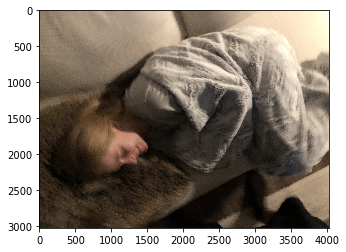

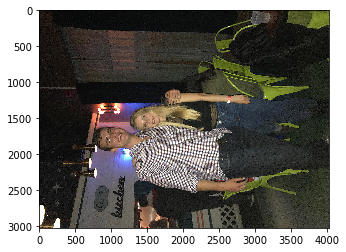

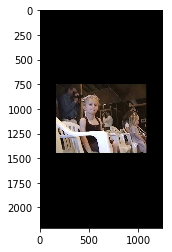

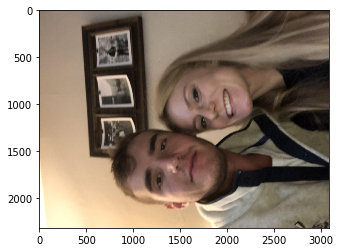

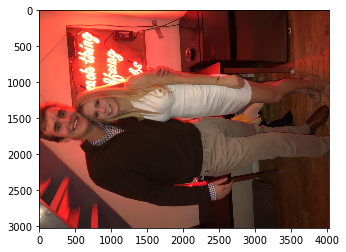

In [7]:
for pic_file in  np.random.choice(os.listdir(), 5):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

In [8]:
os.chdir('../non_clarissa')

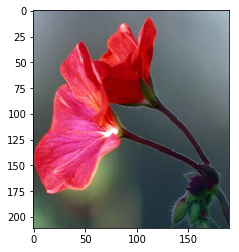

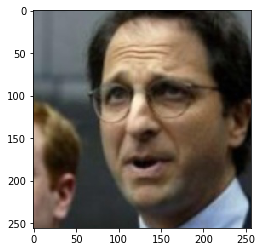

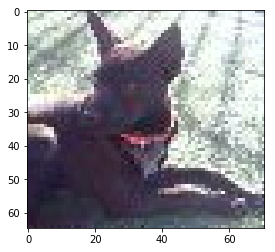

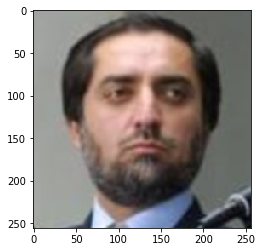

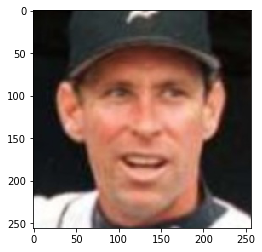

In [14]:
for pic_file in np.random.choice(os.listdir(), 5):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

As you can see, our non_clarissa data is random data from the internet, as well as pictures from my phone which do not contain her. Many are pictures of people's faces, fruit, airplanes, and cars sourced from Kaggle's ImageNet competition dataset. Let's go back into our main folder.

In [15]:
os.chdir('../../..')

In [16]:
print(os.getcwd())

C:\Users\rcapu\OneDrive\Documents\Shared\photo_data


Now, we are ready to try out some models. We are going to train images uniformly as 228 by 228. We can get away with larger dimensional training since our dataset is small and we are running tensorflow on gpu. Let's start with a small convnet. 

## Model Building

### Small Convnet

In [35]:
# Get model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(228, 228, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [36]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [45]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 226, 226, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 226, 226, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 113, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 111, 111, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 111, 111, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 53, 53, 64)        18496     
__________

In [37]:

# Get data generators

batch_size = 16
target_size = (228, 228)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=target_size,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2112 images belonging to 2 classes.
Found 296 images belonging to 2 classes.


In [38]:
from keras.callbacks import EarlyStopping

# Keep only best weights after 7 epochs of no val_acc improvement
callback = EarlyStopping(
    monitor='val_acc', 
    restore_best_weights=True,
    patience=7
)

In [39]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2112 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=296 // batch_size,
        callbacks=[callback]
)
model.save('model_01.h5')  # always save your weights after training or during training

Epoch 1/50
132/132 [==============================] - 173s 1s/step - loss: 0.5276 - acc: 0.7562 - val_loss: 0.4045 - val_acc: 0.8021
Epoch 2/50
132/132 [==============================] - 175s 1s/step - loss: 0.3867 - acc: 0.8381 - val_loss: 0.2784 - val_acc: 0.8714
Epoch 3/50
132/132 [==============================] - 166s 1s/step - loss: 0.3671 - acc: 0.8565 - val_loss: 0.3817 - val_acc: 0.7964
Epoch 4/50
132/132 [==============================] - 172s 1s/step - loss: 0.3112 - acc: 0.8797 - val_loss: 0.3600 - val_acc: 0.8679
Epoch 5/50
132/132 [==============================] - 183s 1s/step - loss: 0.2991 - acc: 0.8897 - val_loss: 0.7639 - val_acc: 0.7964
Epoch 6/50
132/132 [==============================] - 176s 1s/step - loss: 0.3104 - acc: 0.8982 - val_loss: 0.6663 - val_acc: 0.8107
Epoch 7/50
132/132 [==============================] - 179s 1s/step - loss: 0.2966 - acc: 0.8944 - val_loss: 0.6498 - val_acc: 0.8179
Epoch 8/50
132/132 [==============================] - 175s 1s/step - 

As we can see, our validation accuracy maxed out at 92%. This is quite good for a first attempt, especially since our training set is small. Let's examine some validation predictions.

Found 296 images belonging to 2 classes.
Clarissa!


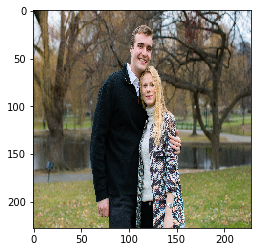


Not Clarissa!


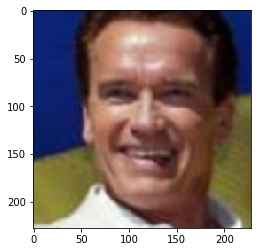


Not Clarissa!


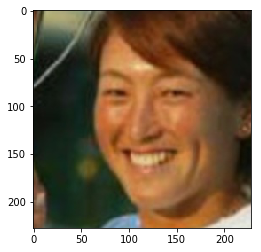


Not Clarissa!


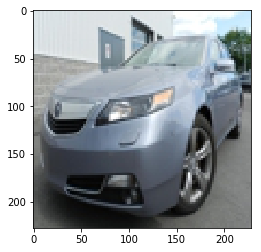


Clarissa!


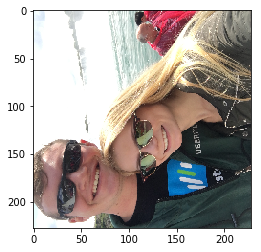


Not Clarissa!


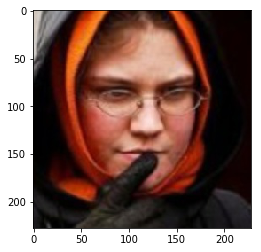


Not Clarissa!


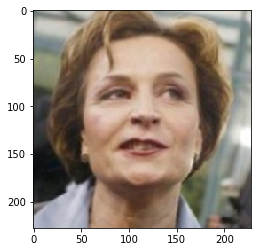


Not Clarissa!


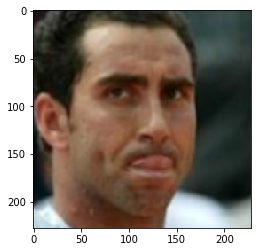


Not Clarissa!


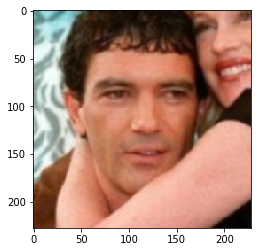


Not Clarissa!


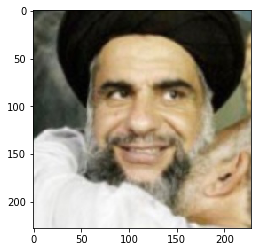

In [41]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=target_size,
        batch_size=1,
        class_mode='binary')

for _ in range(10):
    x = next(validation_generator)[0]
    print('Clarissa!' if model.predict(x)[0][0] < 0.5 else 'Not Clarissa!')
    plt.imshow(x.reshape((228, 228, 3)))
    plt.show()
    print()
    

We can see that our small convnet accurately labeled these 10 pictures.

Let's also plot our model training performance.

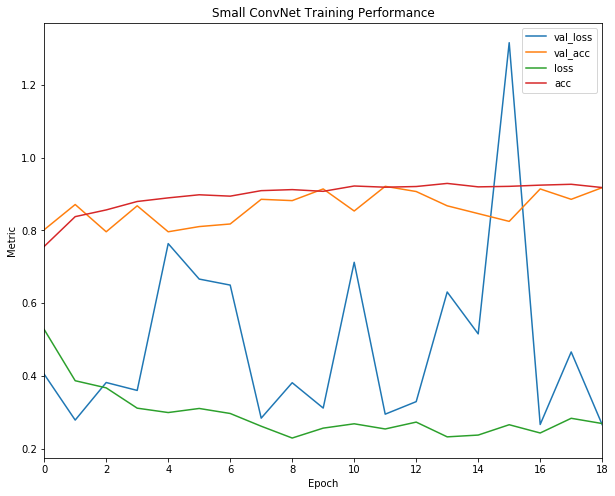

In [47]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title('Small ConvNet Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

It seems that our validation loss was quite stochastic, meaning that each epoch significantly affected model performance on unseen data. It is difficult to say whether or not training more would significantly improve model performance or lead to overfitting. Nonetheless, this is a great start.

Let's now move to using a more advanced network, i.e. one that has pretrained layers. This is a very helpful technique since a pre-trained algorithm already has a very good general understanding of what defines an image in terms of shape, color, and structure. This is mainly because these pre-trained networks are usually very deep and have been trained on millions of diverse images with complex classification tasks. By extracting the general structure of these networks without training them further, we can append a small Dense network to learn how the network represents a Clarissa vs. non-Clarissa picture in hopes that this new model will perform better than a scratch-built model. We will be sourcing  